In [336]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
#Prepocesamiento y normalizacion de datos
from sklearn.preprocessing import StandardScaler
# divicion de los datos en train test
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# Analisis de componentes principales
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
# EStimadores
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
#Modelos Logisticos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
# Medicion de efectividad de modelo
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Optimizacion Parametrica
from sklearn.model_selection import RandomizedSearchCV

In [337]:
import warnings
warnings.filterwarnings("ignore")

# Seleccion de Variables

In [338]:
dataset = pd.read_csv("dataML.csv")
dataset = dataset.drop(columns = "Unnamed: 0" ) 
dataFeatures = dataset.drop(columns="Churn Value")
dataTarget = dataset["Churn Value"]

# Escalamiento de datos: 

In [339]:
scaler = StandardScaler()
dataScaled = scaler.fit_transform(dataFeatures)
dataScaled=  pd.DataFrame(dataScaled, columns= dataFeatures.columns)
dataScaled.head(2)

,Tenure Months,Monthly Charges,Total Charges,Churn Score,CLTV,Senior Citizen_Yes,Gender_Male,Partner_Yes,Dependents_Yes,Phone Service_Yes,...,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Churn Reason_cliente_activo
0,-1.239504,-0.363923,-0.959649,1.267300,-0.983181,-0.440327,0.990658,-0.965608,-0.547115,0.327189,...,-0.079351,-0.079351,-0.087145,-0.121922,-0.05205,-0.053406,-0.118883,-0.12132,-0.11322,-1.662059
1,-1.239504,0.196178,-0.940457,0.384802,-1.438215,-0.440327,-1.009430,-0.965608,1.827769,0.327189,...,-0.079351,-0.079351,11.475158,-0.121922,-0.05205,-0.053406,-0.118883,-0.12132,-0.11322,-1.662059


Division datos test y entranamiento

In [340]:
X_train , X_test , y_train , y_test = train_test_split(dataFeatures , dataTarget , test_size= .30, random_state= 42 , stratify= dataTarget,shuffle=True)

In [341]:
X_train_balanced, y_train_balanced = resample(X_train, y_train, n_samples=len(X_train), random_state=42, replace=True)

# Analisis de Componentes Principales

IPCA

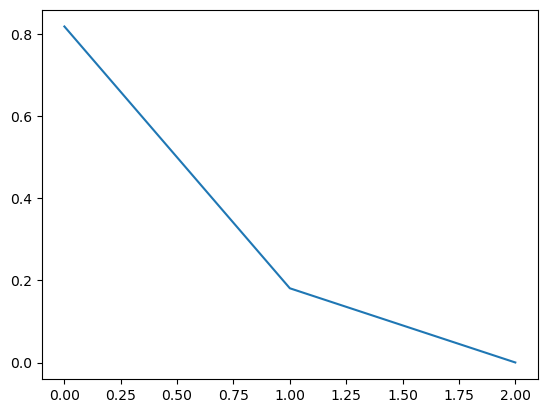

In [342]:
ipca = IncrementalPCA( n_components=3 , batch_size= 10).fit(X_train_balanced)
plt.plot(range(len(ipca.explained_variance_)),ipca.explained_variance_ratio_)

Xipca_train = ipca.transform(X_train_balanced)
Xipca_test =  ipca.transform(X_test)


In [343]:

logistic =  LogisticRegression(
    solver = 'lbfgs').fit(
        Xipca_train, y_train_balanced)
predictions = logistic.predict(Xipca_test)
        
print("SCORE IPCA: ", logistic.score(Xipca_test, y_test))

accuracy = accuracy_score(y_test, predictions)
print(f'Exactitud del modelo: {accuracy:.2f}')



SCORE IPCA:  0.8516587677725118
Exactitud del modelo: 0.85


Notamos que tanto pca como ipca tienen buen score, dado que la variable que intentamos predicir tiene comportamiento lineal con otras. por el contrario el kernel para datos no lineales no es optimo para este modelo.

Usaremos Ipca dado que el set de datos es pequeño y tienen un buen desempeño.

In [344]:
clasificador = RandomForestClassifier()

parametros = {
    'n_estimators': range(90, 130),
    'criterion': [ "gini" , "entropy", "log_loss"],
    'max_depth': range(6 , 11)
}
rand_est = RandomizedSearchCV(
    clasificador, parametros, n_iter=20, cv=3).fit(Xipca_train, y_train_balanced)

print(rand_est.best_estimator_)
print(rand_est.best_params_)

RandomForestClassifier(max_depth=10, n_estimators=98)
{'n_estimators': 98, 'max_depth': 10, 'criterion': 'gini'}


In [362]:
estimator= RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=98).fit(Xipca_train, y_train_balanced)
prediccionBaggin = estimator.predict(Xipca_test)

print(f"""
Presición_Predicción : {accuracy_score(prediccionBaggin, y_test)}
        ------------------------------------------------ """)
cm = confusion_matrix(y_test, prediccionBaggin ,labels= estimator.classes_)
print(cm)


Presición_Predicción : 0.861611374407583
        ------------------------------------------------ 
[[1423  126]
 [ 166  395]]


<Figure size 1100x1100 with 0 Axes>

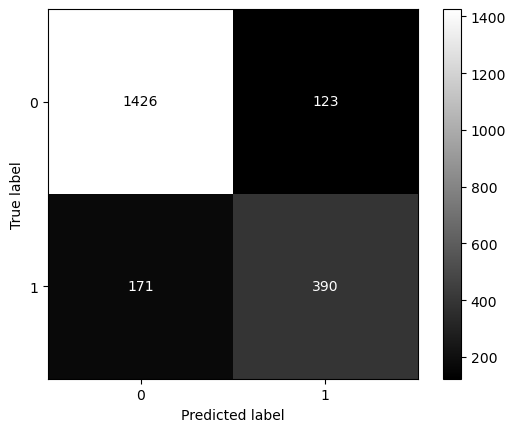

In [359]:
fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test, prediccionBaggin ,labels= estimator.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=estimator.classes_)
disp.plot(cmap='gray')
plt.show()

# Ensambladores :

Baggin

In [352]:
modelos = (
LogisticRegression(solver = "lbfgs", max_iter = 1000), 
DecisionTreeClassifier(),
KNeighborsClassifier(),
RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=123),
LinearSVC(),
SVC(),
SGDClassifier())

In [353]:
def estimadores_bagginIPCA(clasificadores):
    for clasificador in clasificadores:
        modelo = BaggingClassifier(
            base_estimator= clasificador , n_estimators= 30).fit(
            Xipca_train,y_train)
        modelo_predict = modelo.predict(Xipca_test)
        print(f"""
        Clasificador: " {clasificador} 
        N_estamaciones: " {modelo.n_estimators}
        Presición_Predicción : {accuracy_score(modelo_predict , y_test)}
        ------------------------------------------------ """)

estimadores_bagginIPCA(modelos)


        Clasificador: " LogisticRegression(max_iter=1000) 
        N_estamaciones: " 30
        Presición_Predicción : 0.7341232227488151
        ------------------------------------------------ 

        Clasificador: " DecisionTreeClassifier() 
        N_estamaciones: " 30
        Presición_Predicción : 0.6962085308056872
        ------------------------------------------------ 

        Clasificador: " KNeighborsClassifier() 
        N_estamaciones: " 30
        Presición_Predicción : 0.6895734597156398
        ------------------------------------------------ 

        Clasificador: " RandomForestClassifier(max_depth=10, n_estimators=123) 
        N_estamaciones: " 30
        Presición_Predicción : 0.7341232227488151
        ------------------------------------------------ 

        Clasificador: " LinearSVC() 
        N_estamaciones: " 30
        Presición_Predicción : 0.7336492890995261
        ------------------------------------------------ 

        Clasificador: " SVC() 
    

__Prueba__

Boostin

In [349]:
boost = GradientBoostingClassifier(n_estimators=120  , learning_rate=.1 , subsample=1).fit(Xipca_train, y_train_balanced)
boost_pred = boost.predict(Xipca_test)
print("="*64)
print(accuracy_score(boost_pred, y_test))

0.8601895734597157


In [350]:
clasificador = RandomForestClassifier()

parametros = {
    'n_estimators': range(50, 200),
    'criterion': [ "gini" , "entropy", "log_loss"],
    'max_depth': range(2, 11)
}
rand_est = RandomizedSearchCV(
    clasificador, parametros, n_iter=20, cv=3).fit(Xipca_train, y_train_balanced)

print(rand_est.best_estimator_)
print(rand_est.best_params_)

RandomForestClassifier(max_depth=10, n_estimators=98)
{'n_estimators': 98, 'max_depth': 10, 'criterion': 'gini'}


In [354]:
estimator= RandomForestClassifier(criterion=  "entropy" , max_depth=9, n_estimators=109).fit(Xipca_train,y_train_balanced)
prediccionBaggin = estimator.predict(Xipca_test)

print(f"""
Presición_Predicción : {accuracy_score(prediccionBaggin  , y_test)}
        ------------------------------------------------ """)

confusion = confusion_matrix(y_test, prediccionBaggin)
print(confusion)


Presición_Predicción : 0.8644549763033176
        ------------------------------------------------ 
[[1432  117]
 [ 169  392]]


# Score Final: __87 %__